In [1]:
%pylab inline
import pymaster as nmt
import healpy as hp
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [11]:
mask = hp.read_map("/global/homes/j/jharno/IA-infusion/SkySim5000/FullSky_weight.fits")
#Downgrading mask to reasonable size
mask = hp.ud_grade(mask, 512)

In [13]:
# Read mask and apodize it on a scale of ~1deg
mask = nmt.mask_apodization(mask, 1., apotype="Smooth")

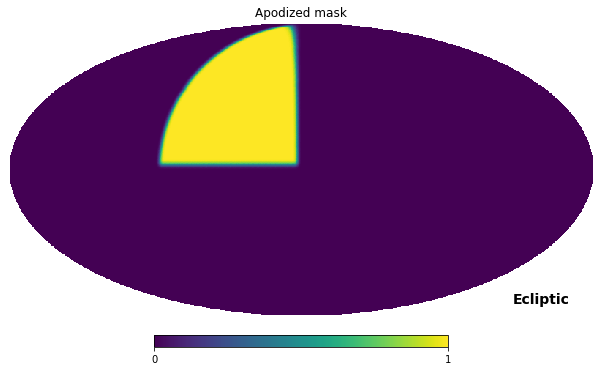

In [14]:
hp.mollview(mask, coord=['E', 'E'], title='Apodized mask')
plt.show()

In [16]:
from astropy.table import Table
# Cool, so now, we need to load a catalog and bin it into healpix maps
catalog = Table.read('/global/cscratch1/sd/jharno/IA_Infusion/GalCat_tomo1_All_0.06GpAM_RA_Dec_g1_g2_w_den_Sij.dat',
                     format='ascii')

In [17]:
catalog

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
78.87699361797168,12.469267561624637,-0.001045874638146683,0.0024737182260280628,1.0,0.4727051778632528,23691488871.730885,8.291889468906985e+17,5.376615844009502e+18,1.8342462907727858e+19
71.37323010505337,31.895558205053064,-0.0038311211254473208,-0.004312589713278459,1.0,0.47166594220827546,32625751215.349937,6.680391671761596e+18,6.254290251808711e+18,5.226298693931174e+18
3.1012577375323085,43.492160697500516,0.0007109455829526528,2.6584413630885187e-05,1.0,0.474249625491063,37626161474.61947,1.8810711513197695e+19,3.3850583791164486e+19,3.713819041501492e+20
44.551703332780725,4.711826852848633,0.0022603395987722246,-0.0004958582201900702,1.0,0.4739729599794592,22234943734.36931,1.8760474431546724e+19,1.0667830432014991e+18,3.4458824112853025e+19
83.94976838167334,68.21278923904417,0.002363674861076336,0.002833223225230835,1.0,0.47247983241904984,22802910916.22908,1.5390207338929185e+19,5.334258028292372e+19,4.758834778207305e+17
49.06494922518992,77.60513657534221,0.0011842788619609323,-0.001926656225044157,1.0,0.4741499199823638,20066239064.348473,3.271181652265887e+17,1.4616393466429925e+19,1.949431892040231e+19
20.365826317212537,3.5556119042707977,0.0033182577579789754,0.0042518573438907565,1.0,0.4739930638535098,73177016573.28818,2.3589043148474643e+20,1.416183847736257e+19,7.333454483740957e+18
72.01584954594371,25.818421799516983,0.005045229971095648,0.0009261662774872893,1.0,0.4729324871785185,24331362857.665092,1.3935835218187053e+19,4.4033687031847485e+19,1.3619423773168419e+20
46.41807764612167,59.069703446741435,-0.003645117594411067,0.0036417050358947835,1.0,0.47224136230277236,21378674252.038815,3.949114029806363e+18,1.6115826448805122e+19,1.159277240521078e+19
